In [ ]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [72]:
import sqlite3
con = sqlite3.connect("Chinook.db")

In [73]:
import pandas as pd

In [74]:
cur = con.cursor()

df = pd.read_sql_query("SELECT * FROM ARTIST LIMIT 5", con)

# Display the result of SQL query stored in the dataframe
df.head()

,ArtistId,Name
0,1,AC/DC
1,2,Accept
2,3,Aerosmith
3,4,Alanis Morissette
4,5,Alice In Chains


In [75]:
df = pd.read_sql_query("SELECT * FROM PLAYLIST LIMIT 5", con)

# Display the result of SQL query stored in the dataframe
df.head()

,PlaylistId,Name
0,1,Music
1,2,Movies
2,3,TV Shows
3,4,Audiobooks
4,5,90’s Music


In [76]:
df = pd.read_sql_query("SELECT * FROM PLAYLISTTRACK LIMIT 5", con)

# Display the result of SQL query stored in the dataframe
df.head()

,PlaylistId,TrackId
0,1,3402
1,1,3389
2,1,3390
3,1,3391
4,1,3392


In [7]:
df = pd.read_sql_query("SELECT * FROM TRACK LIMIT 5", con)

# Display the result of SQL query stored in the dataframe
df.head()

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99


In [84]:
df = pd.read_sql_query('''SELECT t.Name AS TrackName, t.Composer, p.PlaylistId, pt.TrackId
                        FROM Playlist p
                        JOIN PlaylistTrack pt ON p.PlaylistId = pt.PlaylistId
                        JOIN Track t ON pt.TrackId = t.TrackId
                        WHERE p.Name = 'Music'
                        AND t.COMPOSER <> 'None'
                        LIMIT 5''', con)

,TrackName,Composer,PlaylistId,TrackId
0,No Such Thing,Chris Cornell,1,3375
1,Poison Eye,Chris Cornell,1,3376
2,Arms Around Your Love,Chris Cornell,1,3377
3,Safe and Sound,Chris Cornell,1,3378
4,She'll Never Be Your Man,Chris Cornell,1,3379


In [8]:
con.close()

## LangGraph SQL Database Tools

In [9]:
%%capture --no-stderr --no-display
!pip install langgraph langchain_community langchain-anthropic

In [10]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY: ··········


In [11]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(temperature=0, model="claude-3-5-sonnet-20240620")

In [12]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [13]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
print('tools: ', [tool.name for tool in tools])

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
db_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("Artist"))

print(db_query_tool.invoke("SELECT * FROM ARTIST LIMIT 2"))

tools:  ['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/
[(1, 'AC/DC'), (2, 'Accept')]


## LLM Controlled Autonomous Agent

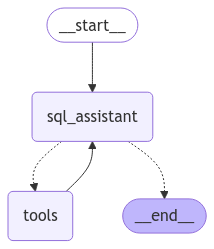

In [14]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

def sql_assistant(state: MessagesState):
  return {'messages': llm.bind_tools(tools).invoke(state['messages'])}


builder.add_node('sql_assistant', sql_assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'sql_assistant')
builder.add_conditional_edges('sql_assistant',
                              # if the last output message is a tool call then goes to the tool node,
                              # uf the last output message is not a tool call then goes to END
                              tools_condition
                              )
builder.add_edge('tools', 'sql_assistant')


graph = builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [16]:
input_message = 'find 2 artists with name starting with a'

In [17]:
for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

find 2 artists with name starting with a
================================== Ai Message ==================================

[{'citations': None, 'text': "Certainly! To find 2 artists with names starting with the letter 'a', we'll need to query the database. First, let's check which tables are available in the database, and then we'll look at the schema of the relevant table before constructing our query.\n\nLet's start by listing the tables in the database:", 'type': 'text'}, {'id': 'toolu_01DKCs3zdMNsbxNcGip722Mi', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}]
Tool Calls:
  sql_db_list_tables (toolu_01DKCs3zdMNsbxNcGip722Mi)
 Call ID: toolu_01DKCs3zdMNsbxNcGip722Mi
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Play

In [46]:
input_message = 'Hello! How are you doing?'

In [47]:
for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hello! How are you doing?
================================== Ai Message ==================================

Hello! I'm doing well, thank you for asking. As an AI assistant, I'm here to help you with any questions or tasks you might have. Is there anything specific you'd like assistance with today? I can help with a wide range of topics or perform various tasks using the tools available to me. Please let me know what you'd like to explore or accomplish.


## Rewrite the Agent with tools control

In [18]:
from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


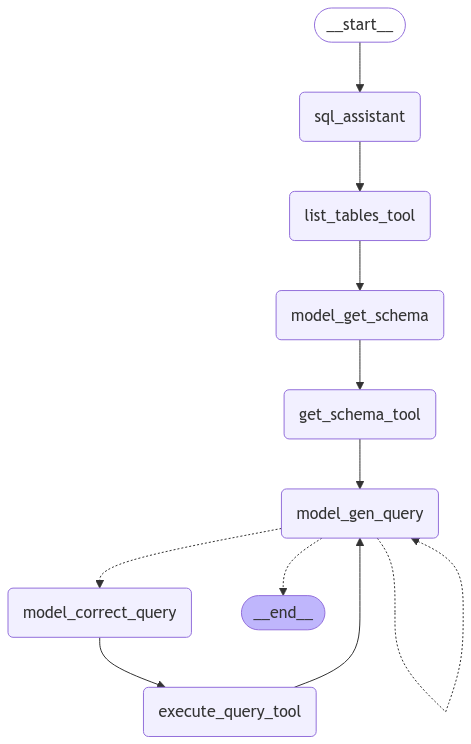

In [67]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

llm_with_tools = llm.bind_tools(tools)

def sql_assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke(state['messages'])}

def model_get_schema(state: MessagesState):
  llm_with_tool = llm.bind_tools([get_schema_tool])
  return {'messages': llm.bind_tools([get_schema_tool]).invoke(state["messages"])}

def model_gen_query(state: MessagesState):
  query_gen_prompt = """You are a SQL expert with a strong attention to detail.
                        Given an input question, output a syntactically correct SQLite query to run. Never output a tool call or tool result, strickly follow this.
                        When generating the query:

                          Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
                          You can order the results by a relevant column to return the most interesting examples in the database.
                          Never query for all the columns from a specific table, only ask for the relevant columns given the question.

                        NEVER make stuff up if you don't have enough information to answer the query, just say you don't have enough information.
                        DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
                        Never output a tool call or tool result.
                        """
  llm_with_tool = llm.bind_tools([get_schema_tool])
  messages = state["messages"] + [SystemMessage(content=query_gen_prompt)]
  return {'messages': llm.bind_tools([get_schema_tool]).invoke(messages)}

def model_correct_query(state: MessagesState):
  query_gen_prompt = """You are a SQL expert with a strong attention to detail.
                        Double check the SQLite query for common mistakes, including:
                        - Using NOT IN with NULL values
                        - Using UNION when UNION ALL should have been used
                        - Using BETWEEN for exclusive ranges
                        - Data type mismatch in predicates
                        - Properly quoting identifiers
                        - Using the correct number of arguments for functions
                        - Casting to the correct data type
                        - Using the proper columns for joins

                        If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

                        You will strictly call the execute_query_tool tool to execute the query after running this check."""

  messages = [SystemMessage(content=query_gen_prompt)] + state["messages"]
  return {'messages': llm.bind_tools([db_query_tool]) .invoke(messages)}



# Define a conditional edge to decide whether to continue or end the workflow
def correct_query_tool_condition(state: MessagesState) -> Literal[END, "model_gen_query", "model_correct_query"]:
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.content == []:
        return END
    elif type(last_message.content) == str and last_message.content.startswith("Error:"):
        return "model_gen_query"
    else:
        return "model_correct_query"


builder.add_node('sql_assistant', sql_assistant)
builder.add_node('list_tables_tool', ToolNode([list_tables_tool]))
builder.add_node('model_get_schema', sql_assistant)
builder.add_node('get_schema_tool', ToolNode([get_schema_tool]))
builder.add_node('model_gen_query', model_gen_query)
builder.add_node('model_correct_query', model_correct_query)
builder.add_node('execute_query_tool', ToolNode([db_query_tool]))


builder.add_edge(START, 'sql_assistant')
builder.add_edge('sql_assistant', 'list_tables_tool')
builder.add_edge('list_tables_tool', 'model_get_schema')
builder.add_edge('model_get_schema', 'get_schema_tool')
builder.add_edge('get_schema_tool', 'model_gen_query')

builder.add_conditional_edges(
    "model_gen_query",
    correct_query_tool_condition,
)
builder.add_edge('model_correct_query', 'execute_query_tool')
builder.add_edge('execute_query_tool', 'model_gen_query')


graph = builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [56]:
input_message = 'find 2 artists whose name starts with a'

In [57]:
for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

find 2 artists whose name starts with a
================================== Ai Message ==================================

[{'citations': None, 'text': "Certainly! To find 2 artists whose name starts with the letter 'a', we'll need to query the database. First, let's check the available tables in the database, then look at the schema of the relevant table, and finally execute a query to find the artists.\n\nLet's start by listing the tables in the database:", 'type': 'text'}, {'id': 'toolu_017wG4PLaNLfrcRvxddbkfps', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}]
Tool Calls:
  sql_db_list_tables (toolu_017wG4PLaNLfrcRvxddbkfps)
 Call ID: toolu_017wG4PLaNLfrcRvxddbkfps
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Play

In [59]:
input_message = 'Name few tracks composed by F. Baltes'

In [69]:
for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
  if event['messages'][-1].content:
     event['messages'][-1].pretty_print()

================================ Human Message =================================

Name few tracks composed by F. Baltes
================================== Ai Message ==================================

[{'citations': None, 'text': "Certainly! To answer your question about tracks composed by F. Baltes, I'll need to query the database. First, let's check what tables we have available, and then we'll look for the appropriate table to find this information.", 'type': 'text'}, {'id': 'toolu_01NeZaMcN8KZp5fyNseabbAd', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}]
Tool Calls:
  sql_db_list_tables (toolu_01NeZaMcN8KZp5fyNseabbAd)
 Call ID: toolu_01NeZaMcN8KZp5fyNseabbAd
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ============

In [90]:
input_message = 'Find few tracks from Music playlist where composer details is available'

In [91]:
for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
  if event['messages'][-1].content:
     event['messages'][-1].pretty_print()

================================ Human Message =================================

Find few tracks from Music playlist where composer details is available
================================== Ai Message ==================================

[{'citations': None, 'text': "Certainly! To find tracks from the Music playlist where composer details are available, we'll need to query the database. Let's start by checking the available tables and then examining the schema of the relevant tables.\n\nFirst, let's list the tables in the database:", 'type': 'text'}, {'id': 'toolu_01Y4q8aYYbhMfrsBrokY7vUE', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}]
Tool Calls:
  sql_db_list_tables (toolu_01Y4q8aYYbhMfrsBrokY7vUE)
 Call ID: toolu_01Y4q8aYYbhMfrsBrokY7vUE
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, P